In [0]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

In [0]:
img_rows, img_cols, img_ch = 28, 28, 1
input_shape = (img_rows, img_cols, img_ch)
batch_size = 256
num_epochs = 50

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_test = X_train / 127.5 - 1., X_test / 127.5 -1

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
X_train = X_train.reshape(-1, *input_shape).astype(np.float32)
X_test = X_test.reshape(-1, *input_shape).astype(np.float32)

In [0]:
BUFFER_SIZE = 200_000
BATCH_SIZE = 128

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
from tensorflow.keras import layers

In [0]:
def generator_model():
  model = tf.keras.Sequential([
          tf.keras.layers.Dense(4 * 4 * 512, input_shape=(100, )),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.LeakyReLU(),

          tf.keras.layers.Reshape(target_shape=(4, 4, 512)),

          tf.keras.layers.Conv2DTranspose(256, (4, 4)),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.LeakyReLU(),
          
          tf.keras.layers.Conv2DTranspose(128, (3, 3), padding='same'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.LeakyReLU(),

          tf.keras.layers.Conv2DTranspose(64, (3, 3), strides = 2, padding='same'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.LeakyReLU(),

          tf.keras.layers.Conv2DTranspose(1, (3, 3), strides=2, padding='same', activation='tanh')
  ])
  return model

In [64]:
generator_model().summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 8192)              827392    
_________________________________________________________________
batch_normalization_66 (Batc (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_66 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_26 (Reshape)         (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_51 (Conv2DT (None, 7, 7, 256)         2097408   
_________________________________________________________________
batch_normalization_67 (Batc (None, 7, 7, 256)         1024      
_________________________________________________________________
leaky_re_lu_67 (LeakyReLU)   (None, 7, 7, 256)       

In [0]:
def discriminator_model():
  model = tf.keras.Sequential([
          tf.keras.layers.Conv2D(64, kernel_size=(5,5), input_shape=(28,28,1), strides=2, padding='same'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.LeakyReLU(),
          tf.keras.layers.Dropout(0.3),

          tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides=2, padding='same'),
          tf.keras.layers.LeakyReLU(),
          tf.keras.layers.Dropout(0.3),

          tf.keras.layers.Conv2D(256, kernel_size=(3,3), strides=2, padding='same'),
          tf.keras.layers.LeakyReLU(),

          tf.keras.layers.Conv2D(512, kernel_size=(3, 3), strides=2, padding='same'),
          tf.keras.layers.LeakyReLU(),
          tf.keras.layers.MaxPooling2D(2),

          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(1),
  ])
  return model

In [71]:
discriminator_model().summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
batch_normalization_73 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_79 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_80 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 7, 128)       

In [0]:
generator = generator_model()
discriminator = discriminator_model()

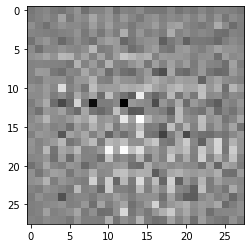

In [73]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [74]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00017942]], shape=(1, 1), dtype=float32)


In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [0]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  return real_loss + fake_loss

In [0]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
BATCH_SIZE = 128
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
  disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

  return gen_loss, disc_loss

In [82]:
EPOCHS = 100
import time

for epoch in range(EPOCHS):
  start = time.time()

  for image_batch in train_dataset:
    gen_loss, disc_loss = train_step(image_batch)
  
  print(f'Epoch {epoch + 1} completed: Time: {time.time() - start}, loss {gen_loss}--{disc_loss}')

Epoch 1 completed: Time: 29.920430660247803, loss 4.574414253234863--0.0968540757894516
Epoch 2 completed: Time: 26.750033378601074, loss 4.623870849609375--0.14559009671211243
Epoch 3 completed: Time: 27.16152024269104, loss 3.802297592163086--0.23389208316802979
Epoch 4 completed: Time: 27.805638074874878, loss 4.238858699798584--0.5961215496063232
Epoch 5 completed: Time: 28.007330179214478, loss 2.9853289127349854--0.38441529870033264
Epoch 6 completed: Time: 27.66465163230896, loss 2.3933141231536865--0.6605682373046875
Epoch 7 completed: Time: 27.83423137664795, loss 2.746776580810547--0.6877554655075073
Epoch 8 completed: Time: 27.78905463218689, loss 2.123626470565796--0.6373639702796936
Epoch 9 completed: Time: 27.71725845336914, loss 2.503605365753174--0.6324149370193481
Epoch 10 completed: Time: 27.72991394996643, loss 1.8813647031784058--0.9045417308807373
Epoch 11 completed: Time: 27.704615354537964, loss 1.8340072631835938--0.7216948866844177
Epoch 12 completed: Time: 27.

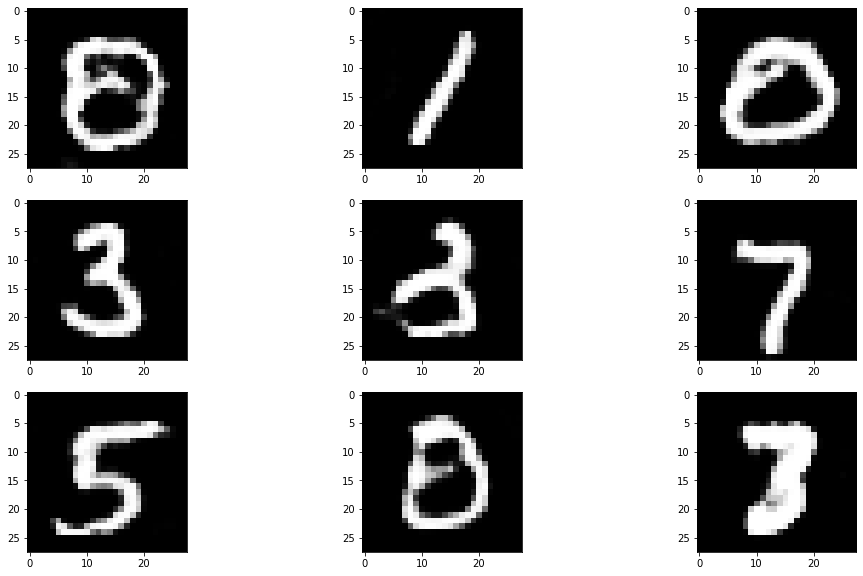

In [100]:
plt.figure(figsize=(17,10))

for val in range(1, 10):
  plt.subplot(3,3,val)
  plt.imshow(generator(tf.random.normal([1, 100]), training=False)[0, :, :, 0], cmap='gray')

In [0]:
BATCH_SIZE = 128
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape:
    generated_images = generator(noise, training=True)

    fake_output = discriminator(generated_images, training = False)

    gen_loss = generator_loss(fake_output)

  gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))

  return gen_loss

In [102]:
EPOCHS = 50
import time

for epoch in range(EPOCHS):
  start = time.time()

  for image_batch in train_dataset:
    gen_loss = train_step(image_batch)
  
  print(f'Epoch {epoch + 1} completed: Time: {time.time() - start}, loss {gen_loss}')

Epoch 1 completed: Time: 16.036341190338135, loss 0.00367566617205739
Epoch 2 completed: Time: 15.057719230651855, loss 0.0008131721988320351
Epoch 3 completed: Time: 15.138899803161621, loss 0.0005040992982685566
Epoch 4 completed: Time: 15.286205291748047, loss 0.0005337586626410484
Epoch 5 completed: Time: 15.44142746925354, loss 0.0002932813949882984
Epoch 6 completed: Time: 15.655419826507568, loss 0.0002017547085415572
Epoch 7 completed: Time: 15.927019834518433, loss 0.00014158073463477194
Epoch 8 completed: Time: 15.94958209991455, loss 8.093338692560792e-05
Epoch 9 completed: Time: 15.69223690032959, loss 8.61568987602368e-05
Epoch 10 completed: Time: 15.693052053451538, loss 5.574618262471631e-05
Epoch 11 completed: Time: 15.765714883804321, loss 2.6845023967325687e-05
Epoch 12 completed: Time: 15.799941778182983, loss 1.819801218516659e-05
Epoch 13 completed: Time: 15.772761106491089, loss 2.348347334191203e-05
Epoch 14 completed: Time: 15.742439985275269, loss 1.07581827251

In [0]:
BATCH_SIZE = 128
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
  disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

  return gen_loss, disc_loss

In [104]:
EPOCHS = 100
import time

for epoch in range(EPOCHS):
  start = time.time()

  for image_batch in train_dataset:
    gen_loss, disc_loss = train_step(image_batch)
  
  print(f'Epoch {epoch + 1} completed: Time: {time.time() - start}, loss {gen_loss}--{disc_loss}')

Epoch 1 completed: Time: 28.823432207107544, loss 2.5106866359710693--0.59033203125
Epoch 2 completed: Time: 27.26766872406006, loss 1.9618337154388428--0.7339624166488647
Epoch 3 completed: Time: 28.05170726776123, loss 2.1434226036071777--0.7499864101409912
Epoch 4 completed: Time: 27.872981548309326, loss 2.240485191345215--0.6233412027359009
Epoch 5 completed: Time: 27.791998624801636, loss 2.4798121452331543--0.7011038064956665
Epoch 6 completed: Time: 27.80189323425293, loss 1.7341327667236328--0.8177409768104553
Epoch 7 completed: Time: 27.841129302978516, loss 2.1673059463500977--0.6765384674072266
Epoch 8 completed: Time: 27.804473161697388, loss 2.213881492614746--0.7751384973526001
Epoch 9 completed: Time: 27.81749987602234, loss 1.9294109344482422--0.743554949760437
Epoch 10 completed: Time: 27.821739673614502, loss 2.0364890098571777--0.8928444385528564
Epoch 11 completed: Time: 27.783836841583252, loss 1.988109827041626--0.7852784395217896
Epoch 12 completed: Time: 27.829

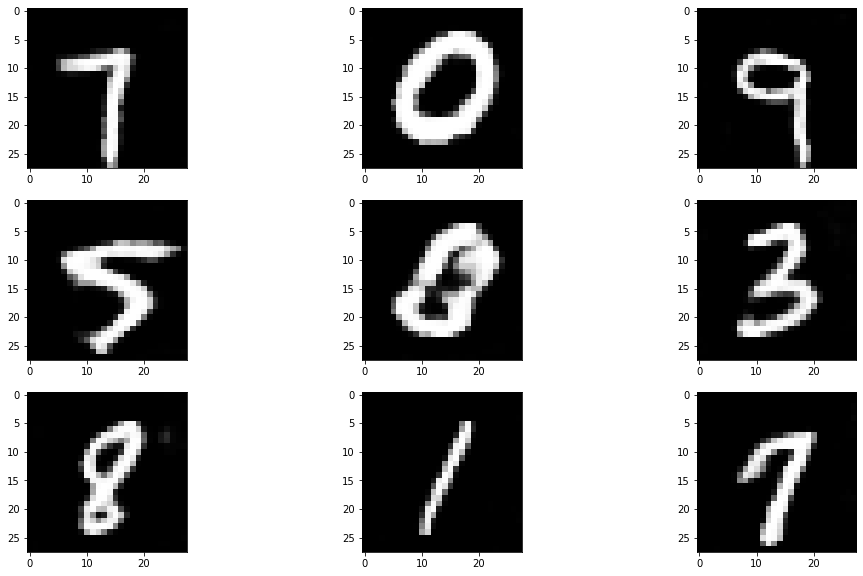

In [105]:
plt.figure(figsize=(17,10))

for val in range(1, 10):
  plt.subplot(3,3,val)
  plt.imshow(generator(tf.random.normal([1, 100]), training=False)[0, :, :, 0], cmap='gray')